In [1]:
import sys
sys.path.append("../src")

In [2]:
import os
import itertools

import cv2
import pyvips
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import get_contours, get_coordinates, get_background_color

In [3]:
data_dir = os.path.join("..", "data", "images")
image_names = os.listdir(data_dir)

print("num images:", len(image_names))

num images: 127


In [4]:
image_paths = [os.path.join(data_dir, i) for i in image_names]

images = [pyvips.Image.new_from_file(f, access="sequential") for f in image_paths]

In [5]:
# smallest_image = images[image_names.index("11000.ome.tif")]
smallest_image = images[0]

smallest_image = smallest_image.numpy()

height, width = smallest_image.shape[:2]

In [6]:
downsampled = cv2.resize(smallest_image, (width // 100, height // 100))

/var/folders/px/_hyh_81j2wx_d8kw_xzcl9hr0000gn/T/ipykernel_23574/2634299058.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


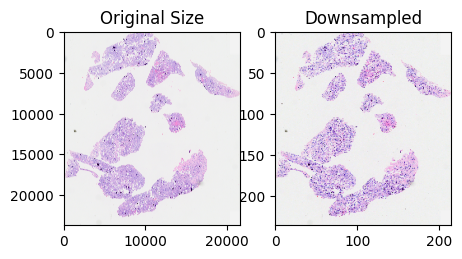

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].imshow(smallest_image)
axes[0].set_title("Original Size")

axes[1].imshow(downsampled)
axes[1].set_title("Downsampled")

fig.show()

In [8]:
contours = get_contours(downsampled)
upscaled_contours = [c * 100 for c in contours]

In [9]:
original_resolution = smallest_image.copy()

for contour in upscaled_contours:
    x, y, w, h = cv2.boundingRect(contour)
    original_resolution = cv2.rectangle(original_resolution, (x, y), (x + w, y + h), (0, 255, 0), 200)

contoured = smallest_image.copy()
contoured = cv2.drawContours(contoured, upscaled_contours, -1, (0, 255, 0), 200)

/var/folders/px/_hyh_81j2wx_d8kw_xzcl9hr0000gn/T/ipykernel_23574/2896348488.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


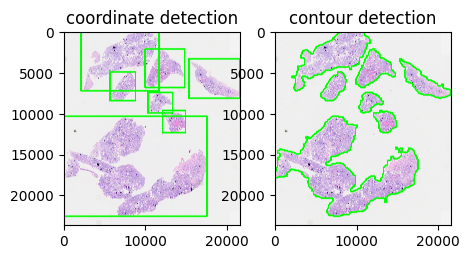

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(5, 10))

axes[0].imshow(original_resolution)
axes[0].set_title("coordinate detection")

axes[1].imshow(contoured)
axes[1].set_title("contour detection")

fig.show()

In [11]:
scaled_contours = [c * 100 for c in contours]

coordinates = get_coordinates(scaled_contours)

coordinates

[(2600, 15300, 5101, 5401), (200, 1100, 13901, 7801)]

In [12]:
coordinates = sorted(coordinates, key=lambda x: (x[1], x[0]))

coordinates

[(200, 1100, 13901, 7801), (2600, 15300, 5101, 5401)]

In [13]:
new_coordinates = []
original_coordinates = sorted(coordinates, key=lambda x: (x[1], x[0]))
max_width = max(coordinates, key=lambda x: x[2])[2]
max_width = max_width if max_width > 10_000 else 10_000

running_max_height = 0
pointer_x, pointer_y = 0, 0

for c in coordinates:
    tissue_width, tissue_height = c[2], c[3] 
    
    if (pointer_x + tissue_width) <= max_width:
        new_coordinates.append((pointer_x, pointer_y, tissue_width, tissue_height))

    else:
        pointer_y += (max(new_coordinates, key=lambda x: (x[0], x[3]))[3] + 10)
        pointer_x = 0
        new_coordinates.append((pointer_x, pointer_y, tissue_width, tissue_height))

    pointer_x += new_coordinates[-1][2] + 10

In [14]:
new_coordinates

[(0, 0, 13901, 7801), (0, 7811, 5101, 5401)]

In [15]:
new_cordinates = []
coordinates = sorted(coordinates, key=lambda x: (x[1], x[0]))
max_width = max(coordinates, key=lambda x: x[2])[2]
max_width = max_width if max_width > 10_000 else 10_000

pointer_x, pointer_y = 0, 0

for c in coordinates:
    tissue_width, tissue_height = c[2], c[3]
    

    if (pointer_x + tissue_width) > max_width:
        pointer_y += (max(new_cordinates, key=lambda x: (x[0], x[3]))[3] + 10)
        pointer_x = 0
    
    new_cordinates.append((pointer_x, pointer_y, tissue_width, tissue_height))
    pointer_x += new_cordinates[-1][2] + 10

In [16]:
new_cordinates

[(0, 0, 13901, 7801), (0, 7811, 5101, 5401)]

In [17]:
row_heights = [max(group, key=lambda x: x[3])[3] + 10 for _, group in itertools.groupby(new_coordinates, key=lambda x: x[1])]

max_height = sum(row_heights)

In [18]:
max_height

13222

In [19]:
processed_image = np.ones((max_height, max_width, 3), dtype=np.uint8) * 255

processed_image.shape

(13222, 13901, 3)

In [20]:
for c in zip(coordinates, new_coordinates):
    x0, y0, w0, h0 = c[0]
    x1, y1, w1, h1 = c[1]

    detected_tissue = smallest_image[y0:y0+h0, x0:x0+w0]
    processed_image[y1:y1+h1, x1:x1+w1] = detected_tissue

In [21]:
bg_color = get_background_color(image=smallest_image)

bg_mask = np.all(processed_image == [255, 255, 255], axis=-1)

processed_image_final = processed_image.copy()
processed_image_final[bg_mask] = bg_color

/var/folders/px/_hyh_81j2wx_d8kw_xzcl9hr0000gn/T/ipykernel_11747/59442330.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


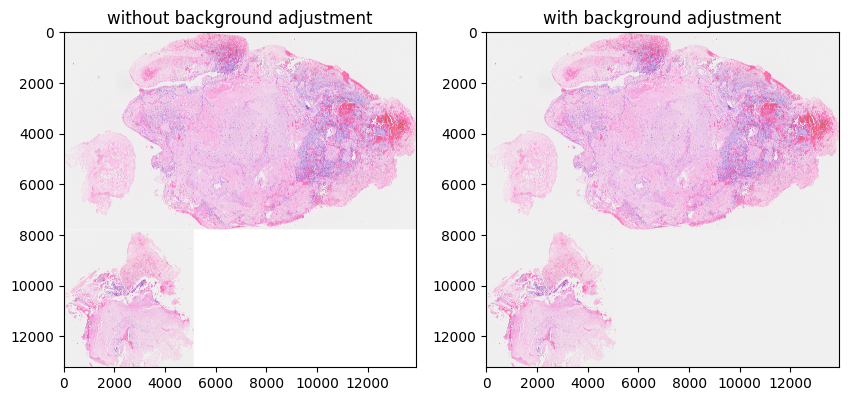

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(processed_image)
axes[0].set_title("without background adjustment")

axes[1].imshow(processed_image_final)
axes[1].set_title("with background adjustment")

fig.show()

In [23]:
processed_image.shape

(13222, 13901, 3)

In [24]:
smallest_image.shape

(28940, 15369, 3)

In [25]:
(smallest_image.shape[0] - processed_image.shape[0], smallest_image.shape[1] - processed_image.shape[1], smallest_image.shape[2] - processed_image.shape[2])

(15718, 1468, 0)